<center><font size = "10"> Week 8 - Synapses<center>
<center><font size = "8">Tutorial 03: Real synaptic trace analysis<center>

<font size='3'><font color='blue'>In this tutorial you will see how to:
    
<font size='3'><font color='blue'>- open and plot synaptic traces from h5 files

<font size='3'><font color='blue'>- extract some parameters from the traces
    
### Features that can be extracted from a synaptic trace
    
<br><img src="images/Synapse_param.png" width="800" height="400">  
    
    
    
The synaptic traces are changes in membrane potential in a postsynaptic cell when the presynaptic cell is stimulated.Features

### 1. Load packages and libraries to be used

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### 2. Open the file and plot

In [2]:
# Open and print keys to check how many sweeps (repetitions) of the experiment there are in the file
data = h5py.File("connection_test.h5", "r")
print(data.keys())

<KeysViewHDF5 ['v0', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']>


In [3]:
# Create a data array and compute the mean trace by computing the mean of all sweeps
traces = []
for key in data.keys():
    traces.append(data.get(key))

traces = np.array(traces)

mean_trace = np.mean(traces, axis=0)

Text(0.5, 0, 'time (ms)')

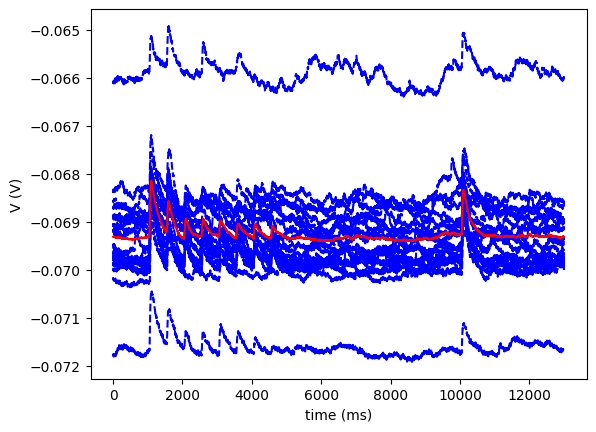

In [4]:
# plot the sweeps and the mean voltage trace
plt.figure()

for trace in traces:
    plt.plot(trace, "b--")

plt.plot(mean_trace, "r")
plt.ylabel('V (V)')
plt.xlabel('time (ms)')

### 3. Extract features from first EPSP: tau rise, latency and amplitude
<font size='3'> According to [Feldmeyer et al., 1999](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2269646/)

In [5]:
def extract_PSP_window(trace, time, stimulation_index, time_before=50, time_after=300):
    """Extract a time window with a single EPSP trace"""
    psp_trace = trace[stimulation_index - time_before : stimulation_index + time_after]
    psp_time = time[stimulation_index - time_before : stimulation_index + time_after]

    return psp_trace, psp_time

In [6]:
def extract_EPSP_features(psp_trace, psp_time, stimulation_time):
    """
    Function takes in a EPSP curve and calculates the following features: amplitude;
    5%, 20% and 80% of the amplitude, tau rise and latency. Based on defintions from
    Feldmeyer et al., 1999.

    Parameters
    ----------
    psp_trace : array with voltage trace [mV]
    psp_time : array of psp times [s]
    stimulation_time : time of the stimulation [s]

    Returns
    -------
    psp_percent : dictionary with psp amplitudes at 5%, 20% and 80% of the amplitude
    times : dictionary with psp times at 5%, 20% and 80% of the amplitude
    amplitude : mplitude of the first EPSP computed as the difference between the 20 and the 80 % of rise
    tau_rise : distance between the time of 20% and 80% of the rise of the EPSP [s]
    latency : time between the AP of the presynaptic cell and 5% amplitude rise of the EPSP [s]
    """

    # find absolute values of the psp trace
    max_psp = np.max(psp_trace)
    min_psp = np.min(psp_trace)
    amplitude_psp = np.abs(max_psp - min_psp)

    # compute percentages of amplitudes
    twenty_amplitude = amplitude_psp * 80.0 / 100.0
    eighty_amplitude = amplitude_psp * 20.0 / 100.0
    five_amplitude = amplitude_psp * 95.0 / 100.0
    amplitude = eighty_amplitude - twenty_amplitude

    # compute amplitude percentages on the psp trace
    psp_percent = {
        "five": -(five_amplitude - max_psp),
        "twenty": -(twenty_amplitude - max_psp),
        "eighty": -(eighty_amplitude - max_psp),
    }

    # find corresponding index of an array
    five_index = np.where(psp_trace >= psp_percent["five"])[0][0]
    twenty_index = np.where(psp_trace >= psp_percent["twenty"])[0][0]
    eighty_index = np.where(psp_trace >= psp_percent["eighty"])[0][0]

    # extract time points for percentage points of the trace
    psp_times = {
        "five": psp_time[five_index],
        "twenty": psp_time[twenty_index],
        "eighty": psp_time[eighty_index],
    }
    
    # calculate time features of a PSP
    tau_rise = np.abs((psp_times["twenty"] - psp_times["eighty"]))
    latency = np.abs((psp_times["five"]) - stimulation_time)

    return psp_percent, psp_times, amplitude, tau_rise, latency

### 3.1 Define time array and stimulation protocol

In [7]:
time = np.linspace(0, 1.3, 13000)
stimulation_indices = np.array([1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 10000])

#### Calculate and visualize the features

In [8]:
stimulation_time = time[stimulation_indices[0]]

psp_trace, psp_time = extract_PSP_window(mean_trace, time, stimulation_indices[0])

psp_percent, psp_times, amplitude, tau_rise, latency = extract_EPSP_features(
    psp_trace, psp_time, stimulation_time
)

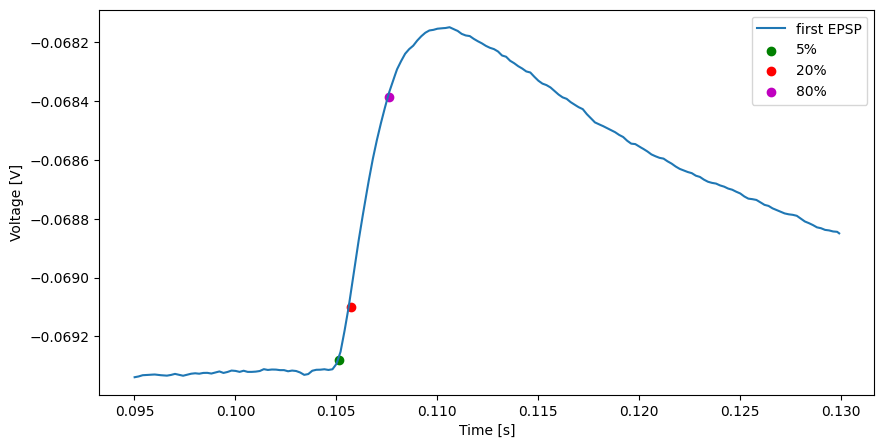

Amplitude =  0.7139286824635049 mV
Tau_rise =  0.0019001461650896279 s
latency =  0.005100392337872142 s


In [9]:
plt.figure(figsize=(10, 5))
plt.plot(psp_time, psp_trace, label="first EPSP")
plt.scatter(psp_times["five"], psp_percent["five"], c="g", label="5%")
plt.scatter(psp_times["twenty"], psp_percent["twenty"], c="r", label="20%")
plt.scatter(psp_times["eighty"], psp_percent["eighty"], c="m", label="80%")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")

plt.legend()
plt.show()

print("Amplitude = ", np.abs(amplitude*1000.0), "mV")
print("Tau_rise = ", tau_rise, "s")
print("latency = ", latency, "s")

### 4. Compute amplitudes of all EPSP of the mean trace

<font size="3">Now we will compute the amplitude in a different way, as the difference between the min and the max voltage point within a pre-defined psp window.

In [10]:
def extract_amplitude(psp_trace):
    """Extract amplitude from a single EPSP trace and convert to mV"""
    max_psp = np.max(psp_trace)
    min_psp = np.min(psp_trace)

    return np.abs(max_psp - min_psp) * 1000

In [11]:
amplitudes = np.array([])

for index in stimulation_indices:
    psp_trace, psp_time = extract_PSP_window(mean_trace, time, index)
    amp = extract_amplitude(psp_trace)

    amplitudes = np.append(amplitudes, amp)

[ 1000  1500  2000  2500  3000  3500  4000  4500 10000] (13000,)


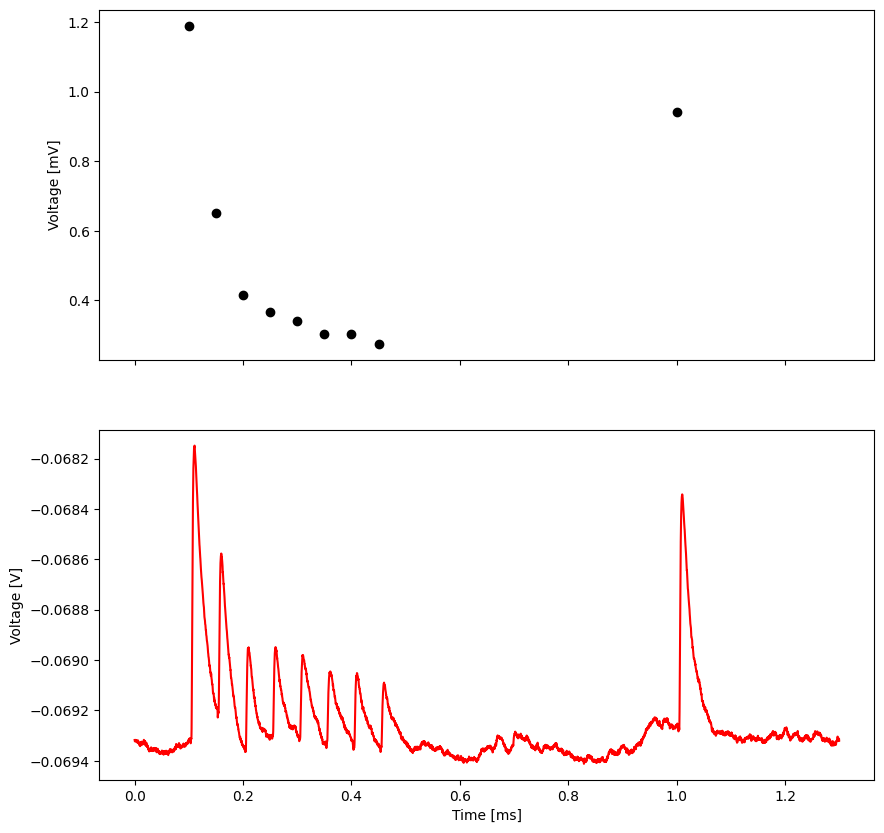

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
print(stimulation_indices, time.shape)
ax[0].scatter(time[stimulation_indices], amplitudes, c="black")
ax[1].plot(time, mean_trace, "r")
ax[0].set_ylabel("Voltage [mV]")
ax[1].set_ylabel("Voltage [V]")
ax[1].set_xlabel("Time [ms]");